---
##### **- Presentado por: Andrés Alfonso, Fernando Duarte, Sebastian Ramirez Garcia y Daniela Uscátegui Bernal**
---


![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

print("* Dimensiones del DataFrame:")
print("  - Número de filas:",data.shape[0])
print("  - Número de columnas:", data.shape[1],"\n")

tipos_de_datos = data.dtypes.value_counts()
print("\n* Conteo de tipos de datos:")
print(tipos_de_datos,"\n")

print("----------------------------")
print("* Head and Tail del DF")
print("----------------------------")
display(data)

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
print("----------------------------")
print("* DF Preprocesado")
print("----------------------------")
data.head()

* Dimensiones del DataFrame:
  - Número de filas: 400000
  - Número de columnas: 6 


* Conteo de tipos de datos:
int64     3
object    3
Name: count, dtype: int64 

----------------------------
* Head and Tail del DF
----------------------------


,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler
...,...,...,...,...,...,...
399995,29900,2015,25287,TX,Lexus,RXRX
399996,17688,2015,17677,MI,Chevrolet,EquinoxFWD
399997,24907,2014,66688,NC,Buick,EnclaveLeather
399998,11498,2014,37872,IN,Volkswagen,Jetta


----------------------------
* DF Preprocesado
----------------------------


,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = X.astype(float)  # Convierte las columnas booleanas a flotante

# Definición de la función para calcular la reducción de varianza
def variance_reduction(X, y, split):
    filter_l = X < split
    y_l, y_r = y[filter_l], y[~filter_l]

    # Calculo de reducción de varianza
    var_parent = np.var(y)
    var_left = np.var(y_l) if len(y_l) > 0 else 0
    var_right = np.var(y_r) if len(y_r) > 0 else 0
    
    gain = var_parent - (var_left * len(y_l) / len(y)) - (var_right * len(y_r) / len(y))
    
    return gain

# Modificación de la función best_split para usar reducción de varianza
def best_split(X, y, num_pct=10):
    
    features = [j for j in range(X.shape[1]) if X.iloc[:, j].dtype != 'bool']

    
    best_split = [0, 0, 0]  # j, split, gain
    
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        for split in splits:
            gain = variance_reduction(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Modificación de la función tree_grow para regresión
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    if X.shape[0] == 1:
        return dict(y_pred=y.iloc[0], level=level, split=-1, n_samples=1, gain=0)
    
    j, split, gain = best_split(X, y, num_pct)
    
    tree = dict(y_pred=y.mean(), level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    if gain < min_gain or (max_depth is not None and level >= max_depth):
        return tree   
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    
    tree['split'] = [j, split]
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain, max_depth, num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain, max_depth, num_pct)
    
    return tree

# Aplicación del árbol de decisión para regresión
tree = tree_grow(X_train, y_train, max_depth=3, min_gain=0.001, num_pct=10)

# 
def tree_predict(X, tree):
    predicted = np.zeros(X.shape[0])

    if tree['split'] == -1:
        predicted[:] = tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l, X_r = X.loc[filter_l], X.loc[~filter_l]

        if X_l.shape[0] == 0:
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

# Predicciones en el set de test
y_pred_test = tree_predict(X_test, tree)

# Cálculo de métricas de error
mse_manual_tree = mean_squared_error(y_test, y_pred_test)
rmse_manual_tree = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_manual_tree = mean_absolute_error(y_test, y_pred_test)

# Impresión de métricas
print("\nDesempeño del árbol de decisión manual:")
print(f"* MSE: {mse_manual_tree:.4f}")
print(f"* RMSE: {rmse_manual_tree:.4f}")
print(f"* MAE: {mae_manual_tree:.4f}")




Desempeño del árbol de decisión manual:
* MSE: 3744956.0023
* RMSE: 1935.1889
* MAE: 1461.3482


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [6]:
# Celda 2

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configuración de la semilla aleatoria para reproducibilidad
np.random.seed(123)

# Definición del número de muestras bootstrap y número de árboles
n_B = 10
n_samples = X_train.shape[0]

# Creación de 10 muestras bootstrap para entrenamiento
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_B)]

# Definición del modelo base (Árbol de Decisión para Regresión)
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra bootstrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_bootstrap = X_train.iloc[sample, :]
    y_train_bootstrap = y_train.iloc[sample]
    
    treereg.fit(X_train_bootstrap, y_train_bootstrap)
    y_pred.iloc[:, i] = treereg.predict(X_test)

# Desempeño de cada árbol individual
print("\nError de cada árbol (RMSE):")
for i in range(n_B):
    error = np.sqrt(mean_squared_error(y_pred.iloc[:, i], y_test))
    print(f"Árbol {i}: RMSE = {error:.4f}")

# Predicción final: promedio de todas las predicciones (votación por promedio)
y_pred_mean = y_pred.mean(axis=1)

# Cálculo de métricas de desempeño del modelo Bagging
mse_bagging_manual = mean_squared_error(y_test, y_pred_mean)
rmse_bagging_manual = np.sqrt(mse_bagging_manual)
mae_bagging_manual = mean_absolute_error(y_test, y_pred_mean)

print("\nDesempeño del modelo Bagging (promedio de predicciones):")
print(f"* MSE: {mse_bagging_manual:.4f}")
print(f"* RMSE: {rmse_bagging_manual:.4f}")
print(f"* MAE: {mae_bagging_manual:.4f}")



Error de cada árbol (RMSE):
Árbol 0: RMSE = 2141.6134
Árbol 1: RMSE = 2136.3520
Árbol 2: RMSE = 2122.7188
Árbol 3: RMSE = 2087.2790
Árbol 4: RMSE = 2168.5187
Árbol 5: RMSE = 2113.8811
Árbol 6: RMSE = 2127.9335
Árbol 7: RMSE = 2184.4148
Árbol 8: RMSE = 2138.1072
Árbol 9: RMSE = 2132.0975

Desempeño del modelo Bagging (promedio de predicciones):
* MSE: 3227180.8177
* RMSE: 1796.4356
* MAE: 1340.0161


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [7]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import log

# Calcular max_features como log(n_features)
n_features = X_train.shape[1]
max_features_value = int(np.log(n_features)) 

# Definición del modelo Bagging con DecisionTreeRegressor
bagreg = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    max_features=max_features_value,
    n_estimators=10, 
    bootstrap=True,
    oob_score=True,  # Habilitar evaluación Out-of-Bag
    random_state=1
)

# Entrenamiento del modelo en el conjunto de entrenamiento
bagreg.fit(X_train, y_train)

# Predicción sobre el conjunto de test
y_pred = bagreg.predict(X_test)

# Cálculo de métricas de error
mse_bagging = mean_squared_error(y_test, y_pred)
rmse_bagging = np.sqrt(mse_bagging)
mae_bagging = mean_absolute_error(y_test, y_pred)

print("\nDesempeño del modelo Bagging con librería:")
print(f"* MSE: {mse_bagging:.4f}")
print(f"* RMSE: {rmse_bagging:.4f}")
print(f"* MAE: {mae_bagging:.4f}")
print(f"* R² Out-of-Bag Score: {bagreg.oob_score_:.4f}")



Desempeño del modelo Bagging con librería:
* MSE: 7134309.3714
* RMSE: 2671.0128
* MAE: 2074.9761
* R² Out-of-Bag Score: 0.2993


In [8]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import log

# Calcular max_features como log(n_features)
n_features = X_train.shape[1]

# Definición del modelo Bagging con DecisionTreeRegressor
bagreg = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=10, 
    bootstrap=True,
    oob_score=True,  # Habilitar evaluación Out-of-Bag
    random_state=1
)

# Entrenamiento del modelo en el conjunto de entrenamiento
bagreg.fit(X_train, y_train)

# Predicción sobre el conjunto de test
y_pred = bagreg.predict(X_test)

# Cálculo de métricas de error
mse_bagging = mean_squared_error(y_test, y_pred)
rmse_bagging = np.sqrt(mse_bagging)
mae_bagging = mean_absolute_error(y_test, y_pred)

print("\nDesempeño del modelo Bagging con librería:")
print(f"* MSE: {mse_bagging:.4f}")
print(f"* RMSE: {rmse_bagging:.4f}")
print(f"* MAE: {mae_bagging:.4f}")
print(f"* R² Out-of-Bag Score: {bagreg.oob_score_:.4f}")


Desempeño del modelo Bagging con librería:
* MSE: 3191255.9302
* RMSE: 1786.4087
* MAE: 1332.3965
* R² Out-of-Bag Score: 0.6084


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [9]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# Definición del modelo Random Forest para regresión
rfreg = RandomForestRegressor(
    n_estimators=100,  # Número de árboles en el bosque
    max_features='sqrt',  # Selección de características (raíz cuadrada del número de variables)
    max_depth=None,  # Sin límite de profundidad
    bootstrap=True,  # Uso de muestras bootstrap
    random_state=42,  # Reproducibilidad
    oob_score=True  # Evaluación Out-of-Bag
)

# Entrenamiento del modelo
rfreg.fit(X_train, y_train)

# Predicción sobre el conjunto de test
y_pred_rf = rfreg.predict(X_test)

# Cálculo de métricas de error
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Impresión de resultados del modelo Random Forest
print("\nDesempeño del modelo Random Forest:")
print(f"* MSE: {mse_rf:.4f}")
print(f"* RMSE: {rmse_rf:.4f}")
print(f"* MAE: {mae_rf:.4f}")
print(f"* R² Out-of-Bag Score: {rfreg.oob_score_:.4f}")



Desempeño del modelo Random Forest:
* MSE: 3208464.0607
* RMSE: 1791.2186
* MAE: 1336.6140
* R² Out-of-Bag Score: 0.7978


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

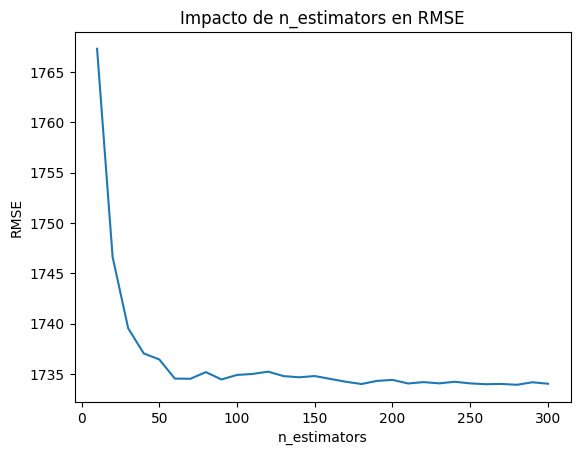

Mejor n_estimators: 280


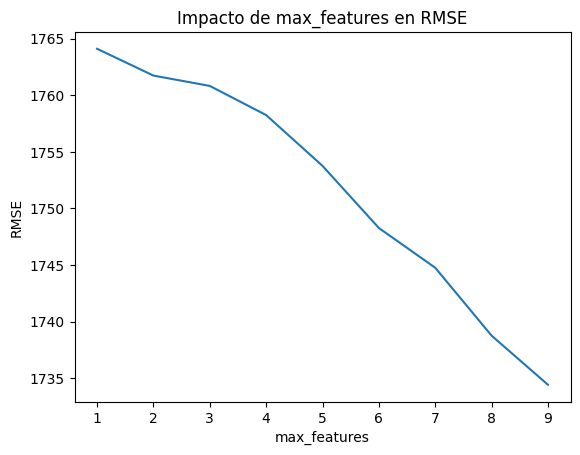

Mejor max_features: 9

Importancia de características en el modelo Random Forest:
       Feature  Importance
0         Year    0.543090
1      Mileage    0.396895
3   M_Camry4dr    0.021123
8   M_CamryXLE    0.015443
6    M_CamryLE    0.007732
2      M_Camry    0.007637
7    M_CamrySE    0.006441
5     M_CamryL    0.001184
4  M_CamryBase    0.000455


In [10]:
# Celda 5

import matplotlib.pyplot as plt

# Lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)
rmse_scores = []

# Uso de 5-fold cross-validation para evaluar diferentes valores de n_estimators
for estimator in estimator_range:
    rf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    rmse_scores.append(np.mean(np.sqrt(-cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))))

# Gráfica del desempeño vs cantidad de árboles
plt.plot(estimator_range, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('Impacto de n_estimators en RMSE')
plt.show()

# Encontrar el mejor n_estimators (el que minimiza RMSE)
best_n_estimators = estimator_range[np.argmin(rmse_scores)]
print(f"Mejor n_estimators: {best_n_estimators}")

# Ajuste de max_features
feature_range = range(1, X_train.shape[1] + 1)
rmse_scores = []

# Evaluación de diferentes valores de max_features
for feature in feature_range:
    rf = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    rmse_scores.append(np.mean(np.sqrt(-cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))))

# Gráfica del desempeño vs cantidad de características
plt.plot(feature_range, rmse_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.title('Impacto de max_features en RMSE')
plt.show()

# Encontrar el mejor max_features (el que minimiza RMSE)
best_max_features = feature_range[np.argmin(rmse_scores)]
print(f"Mejor max_features: {best_max_features}")

# Definición del modelo con los mejores parámetros encontrados
rf_best = RandomForestRegressor(n_estimators=200, max_features=6, random_state=1, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Evaluación de la importancia de cada característica
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_best.feature_importances_})
print("\nImportancia de características en el modelo Random Forest:")
print(feature_importances.sort_values('Importance', ascending=False))



In [11]:
rf_final = RandomForestRegressor(n_estimators=60, max_depth=8, max_features=9, random_state=1, n_jobs=-1)
rf_final.fit(X_train, y_train)

y_pred_final = rf_final.predict(X_test)

# Evaluar el modelo final
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_test, y_pred_final)

print("\nDesempeño del modelo optimizado:")
print(f"* MSE: {mse_final:.4f}")
print(f"* RMSE: {rmse_final:.4f}")
print(f"* MAE: {mae_final:.4f}")


Desempeño del modelo optimizado:
* MSE: 2450557.8251
* RMSE: 1565.4258
* MAE: 1151.0719


In [12]:
rf_final = RandomForestRegressor(n_estimators=180, max_depth=8, max_features=9, random_state=1, n_jobs=-1)
rf_final.fit(X_train, y_train)

y_pred_final = rf_final.predict(X_test)

# Evaluar el modelo final
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_test, y_pred_final)

print("\nDesempeño del modelo optimizado:")
print(f"* MSE: {mse_final:.4f}")
print(f"* RMSE: {rmse_final:.4f}")
print(f"* MAE: {mae_final:.4f}")


Desempeño del modelo optimizado:
* MSE: 2450879.2909
* RMSE: 1565.5284
* MAE: 1151.0076


In [13]:
rf_final = RandomForestRegressor(n_estimators=160, max_depth=8, max_features=6, random_state=1, n_jobs=-1)
rf_final.fit(X_train, y_train)

y_pred_final = rf_final.predict(X_test)

# Evaluar el modelo final
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_test, y_pred_final)

print("\nDesempeño del modelo optimizado:")
print(f"* MSE: {mse_final:.4f}")
print(f"* RMSE: {rmse_final:.4f}")
print(f"* MAE: {mae_final:.4f}")


Desempeño del modelo optimizado:
* MSE: 2422705.6245
* RMSE: 1556.5043
* MAE: 1141.4379


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [14]:
# Celda 6
# Instalación de la librería XGBoost si es necesario
#!pip install xgboost

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Definición del modelo XGBoost para regresión
xgbreg = xgb.XGBRegressor()

# Entrenamiento del modelo
xgbreg.fit(X_train, y_train)

# Predicción sobre el conjunto de test
y_pred_xgb = xgbreg.predict(X_test)

# Cálculo de métricas de error
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("\nDesempeño del modelo XGBoost:")
print(f"* MSE: {mse_xgb:.4f}")
print(f"* RMSE: {rmse_xgb:.4f}")
print(f"* MAE: {mae_xgb:.4f}")



Desempeño del modelo XGBoost:
* MSE: 2576781.0000
* RMSE: 1605.2355
* MAE: 1185.2273


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

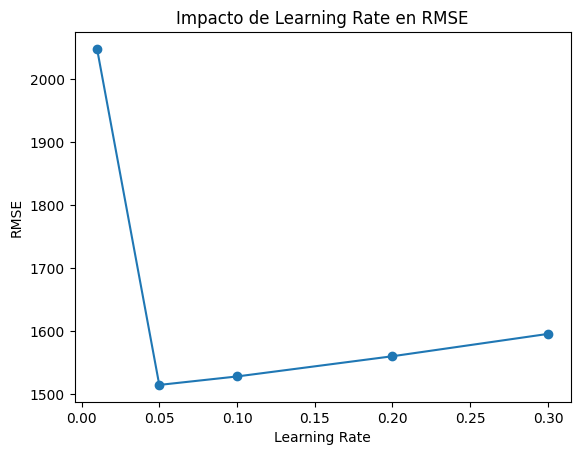

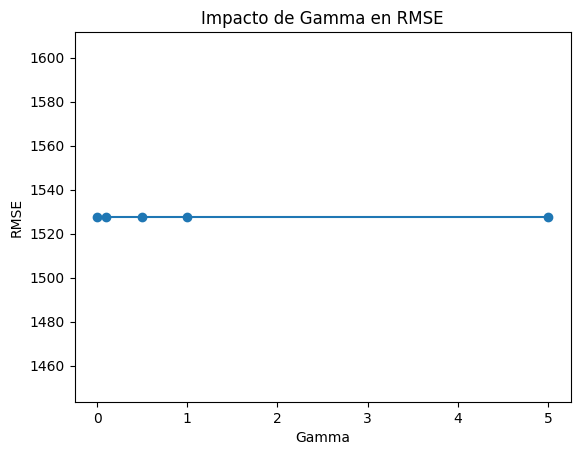

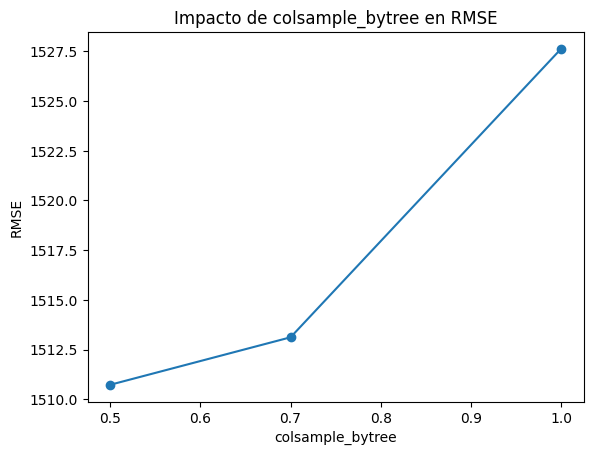


Mejor Learning Rate: 0.05
Mejor Gamma: 0
Mejor colsample_bytree: 0.5

Desempeño del modelo XGBoost optimizado:
* MSE: 2422814.0000
* RMSE: 1556.5391
* MAE: 1146.4637


In [15]:
# Celda 7

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Calibración del learning_rate
lr_values = [0.01, 0.05, 0.1, 0.2, 0.3]
rmse_scores_lr = []

for lr in lr_values:
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=lr, max_depth=6, gamma=0, colsample_bytree=1.0, random_state=1)
    rmse_scores_lr.append(np.mean(np.sqrt(-cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))))

plt.plot(lr_values, rmse_scores_lr, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('Impacto de Learning Rate en RMSE')
plt.show()

# Calibración del gamma
gamma_values = [0, 0.1, 0.5, 1, 5]
rmse_scores_gamma = []

for gamma in gamma_values:
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, gamma=gamma, colsample_bytree=1.0, random_state=1)
    rmse_scores_gamma.append(np.mean(np.sqrt(-cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))))

plt.plot(gamma_values, rmse_scores_gamma, marker='o')
plt.xlabel('Gamma')
plt.ylabel('RMSE')
plt.title('Impacto de Gamma en RMSE')
plt.show()

# Calibración del colsample_bytree
colsample_values = [0.5, 0.7, 1.0]
rmse_scores_colsample = []

for colsample in colsample_values:
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, gamma=0, colsample_bytree=colsample, random_state=1)
    rmse_scores_colsample.append(np.mean(np.sqrt(-cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))))

plt.plot(colsample_values, rmse_scores_colsample, marker='o')
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')
plt.title('Impacto de colsample_bytree en RMSE')
plt.show()

# Obtener los mejores hiperparámetros
best_learning_rate = lr_values[np.argmin(rmse_scores_lr)]
best_gamma = gamma_values[np.argmin(rmse_scores_gamma)]
best_colsample = colsample_values[np.argmin(rmse_scores_colsample)]

print(f"\nMejor Learning Rate: {best_learning_rate}")
print(f"Mejor Gamma: {best_gamma}")
print(f"Mejor colsample_bytree: {best_colsample}")

# Entrenar el modelo final con los mejores hiperparámetros
xgb_final = xgb.XGBRegressor(n_estimators=100, learning_rate=best_learning_rate, max_depth=6,
                             gamma=best_gamma, colsample_bytree=best_colsample, random_state=1)
xgb_final.fit(X_train, y_train)

y_pred_final = xgb_final.predict(X_test)

# Evaluar el modelo final
mse_final_xgb = mean_squared_error(y_test, y_pred_final)
rmse_final_xgb = np.sqrt(mse_final_xgb)
mae_final_xgb = mean_absolute_error(y_test, y_pred_final)

print("\nDesempeño del modelo XGBoost optimizado:")
print(f"* MSE: {mse_final_xgb:.4f}")
print(f"* RMSE: {rmse_final_xgb:.4f}")
print(f"* MAE: {mae_final_xgb:.4f}")



### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [16]:
# Celda 8
